<a href="https://colab.research.google.com/github/ritwikraha/Open-Generative-Fill/blob/main/experiments/SAM_GroundingDINO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq git+https://github.com/IDEA-Research/GroundingDINO.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 11.2 MB/s eta 0:00:00


In [11]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import torch

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BlipProcessor,
    BlipForConditionalGeneration,
)
from groundingdino.util.inference import Model as GroundingDINO
from transformers import SamModel, SamProcessor

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/v0.1.0-alpha2/groundingdino/config/GroundingDINO_SwinT_OGC.py
!wget -q --output-document dog.jpeg https://i.imgur.com/CiAbKbS.jpeg

In [7]:
image = np.array(Image.open("dog.jpeg"))

In [6]:
CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "groundingdino_swint_ogc.pth"

grounding_dino = GroundingDINO(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
boxes = grounding_dino.predict_with_caption(
    image.astype(np.uint8),
    "dog"
)
boxes = boxes[0].xyxy

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [19]:
boxes = [boxes]

In [13]:
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [40]:
inputs = processor(image, input_boxes=boxes, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

In [41]:
mask = masks[0][0]

In [42]:
mask.shape

torch.Size([3, 4000, 6000])

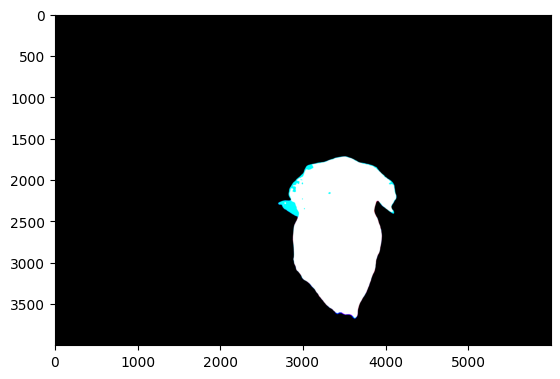

In [46]:
plt.imshow(mask.numpy().transpose(1, 2, 0))